# Finding Stars in Raw Images

This notebook is going to go through an algorithm I developped to blindly detect all star-like objects in a random image of the sky.

In [1]:
"""
IMPORTS
"""
 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import urllib as url
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import os
import helper_functions as ta_funcs
from matplotlib.ticker import MultipleLocator
"""
CONSTANTS
"""

FOLDER = '/home/jacob/AST325/AST325-Lab3/15eunomia'

SyntaxError: invalid syntax (<ipython-input-1-b85b6a12b7b0>, line 12)

DATE AND TIME OF OBSERVATION: 2020-11-12T11:10:20
APPROXIMATE CENTER OF THE OBSERVING FIELD (RA/DEC): ['08 43 02.00', '+20 26 53.0']


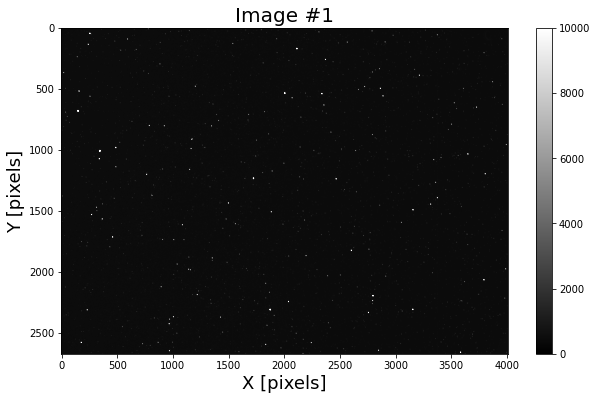

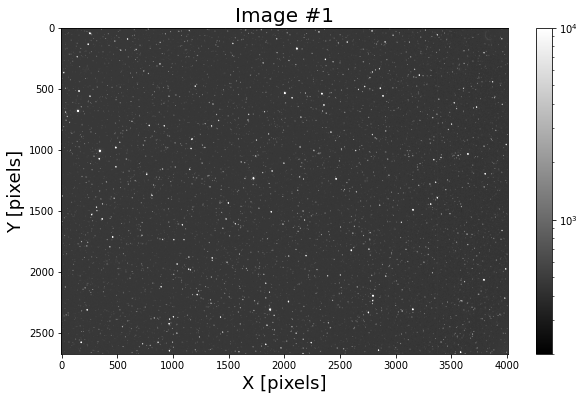

In [2]:
filename = 'calibrated-T14-suresh-Eunomia-20201111-040521-V-BIN1-E-300-001.fit'
hdr , data, center_of_field = ta_funcs.read_file(filename, FOLDER)

center_of_field[0] = '09' + center_of_field[0][2:]

#Plot the image on linear scale
plt.figure(figsize=(10,6))
plt.imshow(data, aspect='auto', cmap = 'gray',vmax = 1e4)
plt.xlabel("X [pixels]", size=18)
plt.ylabel("Y [pixels]", size=18)
plt.title("Image #1", size = 20)
plt.colorbar()
plt.show()

#Plot the image on log scale
plt.figure(figsize=(10,6))
plt.imshow(data, aspect='auto', cmap = 'gray', 
           norm = LogNorm(vmax = 1e4, vmin = 2e2))
plt.xlabel("X [pixels]", size=18)
plt.ylabel("Y [pixels]", size=18)
plt.title("Image #1", size = 20)
plt.colorbar()
plt.show()

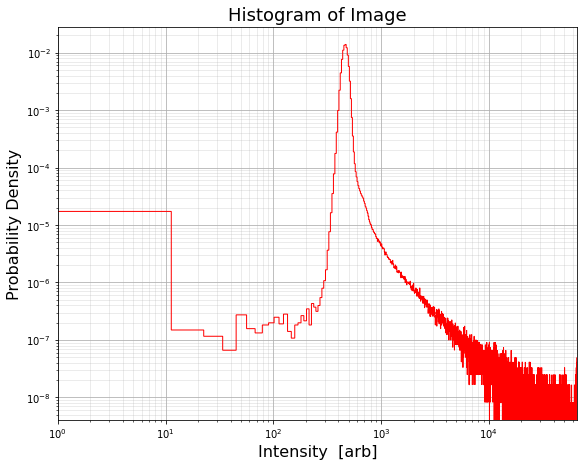

In [3]:
plt.figure(figsize = (8,6))

subarray = data[:,:]
plt.hist(subarray.flatten(), 
         bins = 'scott',
         density = True,
         histtype = 'step',
         color = 'r')
plt.tight_layout()
plt.grid(alpha=0.3,which='minor')
plt.grid(alpha=1,which='major')
plt.yscale('log')
plt.xlim(np.min(subarray),np.max(subarray))
plt.title("Histogram of Image", size=18)
plt.xlabel("Intensity  [arb]", size=16)
plt.ylabel("Probability Density", size=16)
plt.xlim(1e0,2**16)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [4]:
star_locations = ta_funcs.find_stars(data, NSTARS = 100, boxsize = 30)

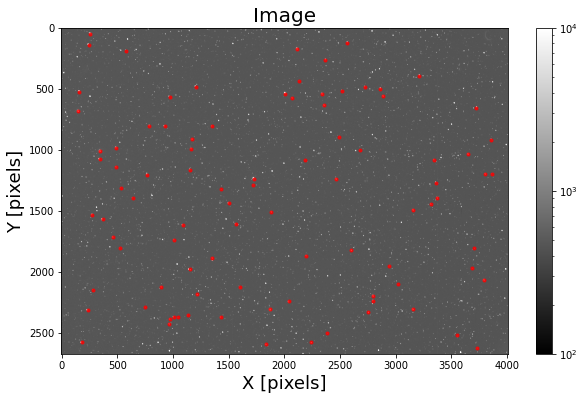

In [5]:
plt.figure(figsize=(10,6))
plt.imshow(data, aspect='auto', cmap = 'gray', 
           norm = LogNorm(vmax = 1e4, vmin = 1e2))
plt.plot(star_locations[:,1], star_locations[:,0], '.', 
         color='r', alpha = 0.8)
plt.xlabel("X [pixels]", size=18)
plt.ylabel("Y [pixels]", size=18)
plt.title("Image", size = 20)
plt.colorbar()
plt.show()

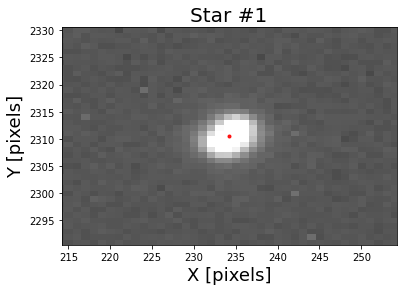

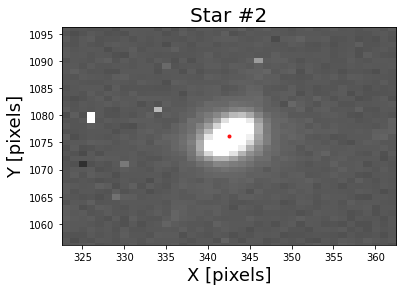

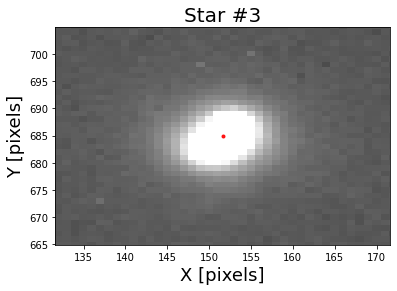

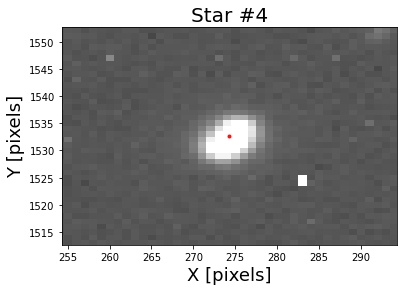

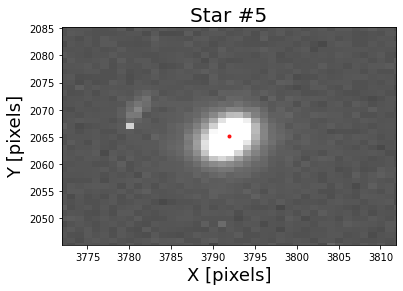

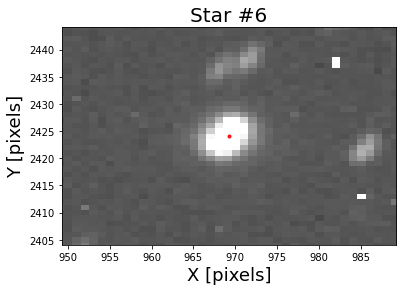

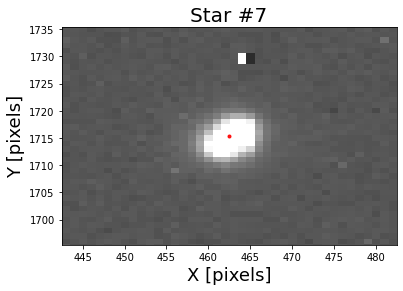

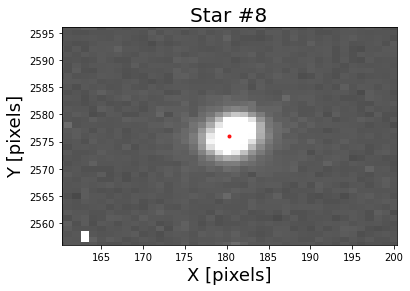

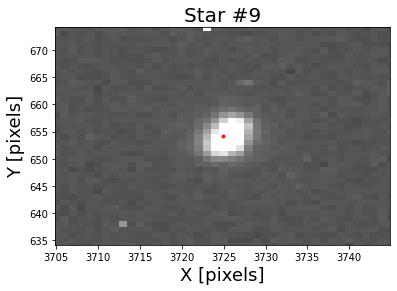

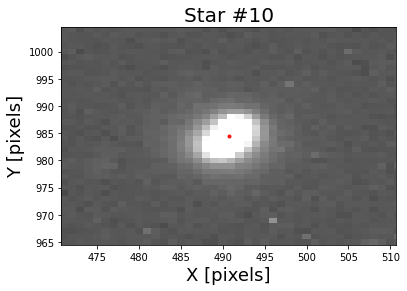

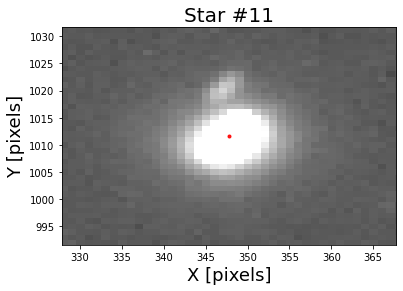

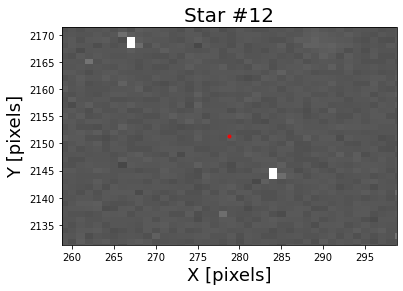

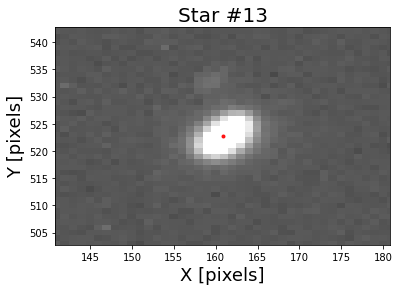

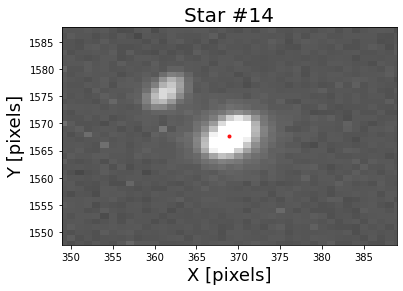

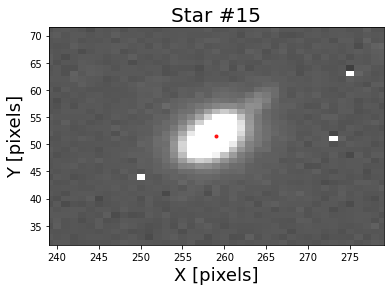

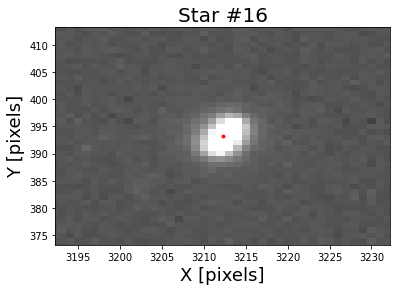

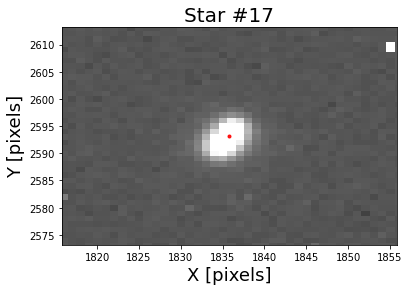

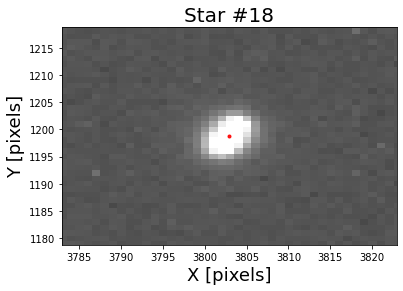

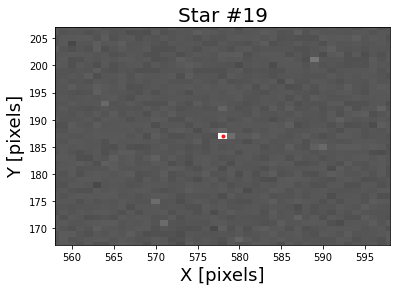

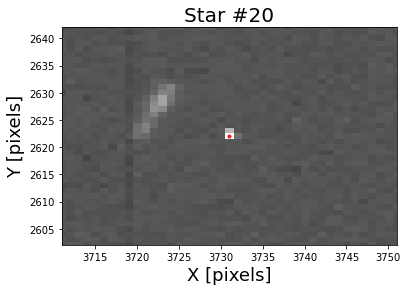

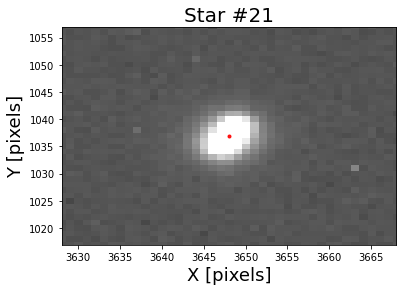

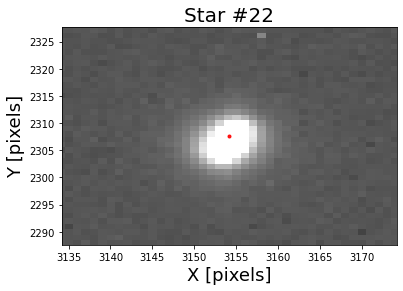

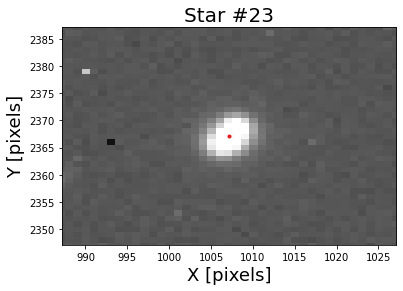

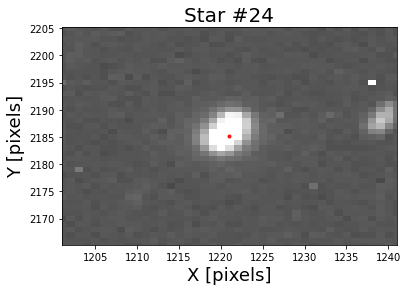

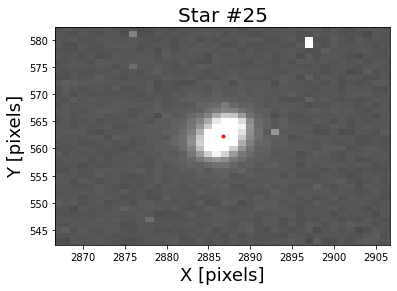

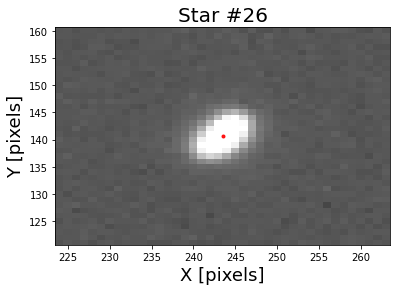

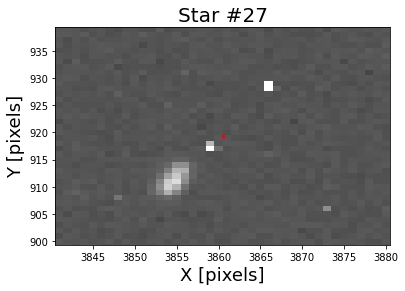

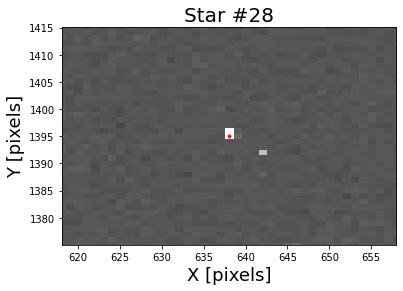

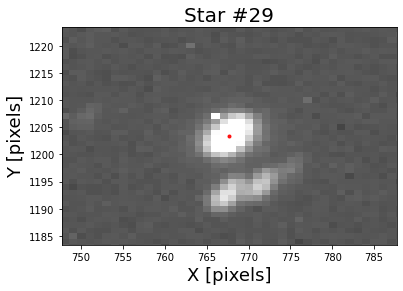

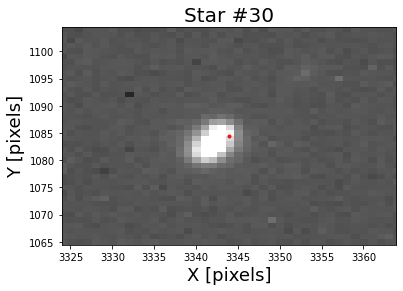

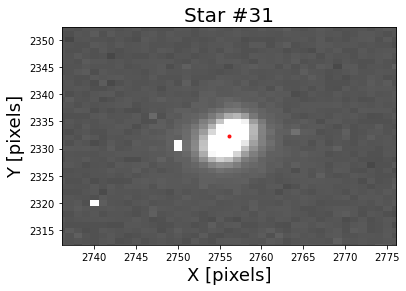

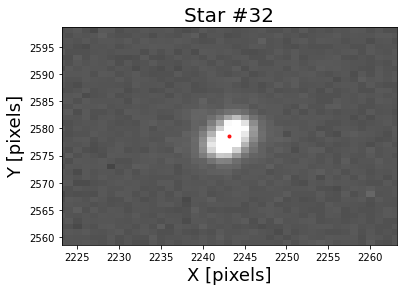

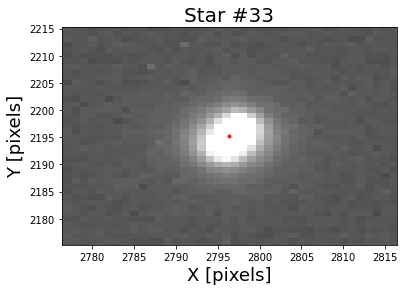

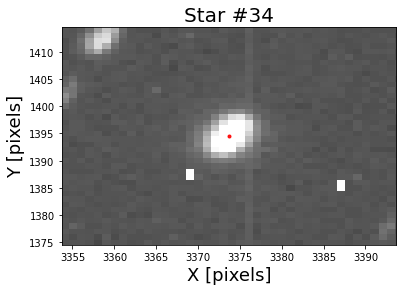

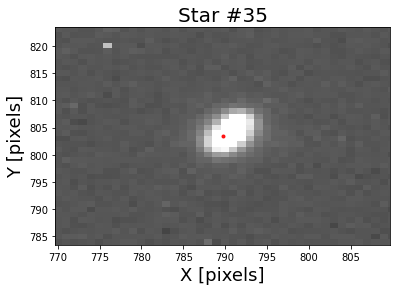

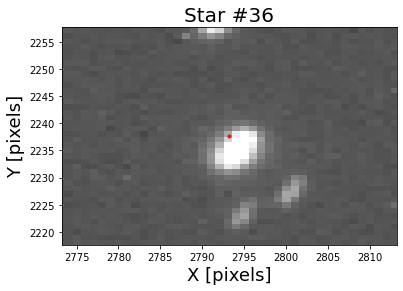

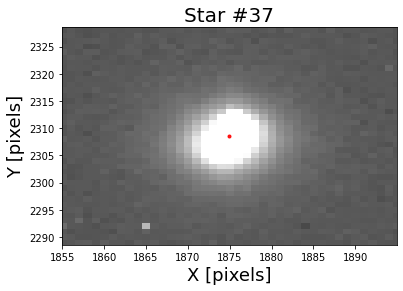

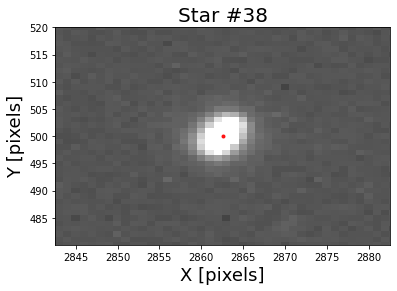

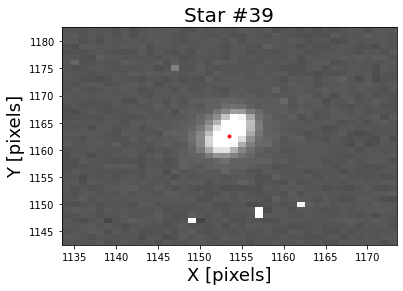

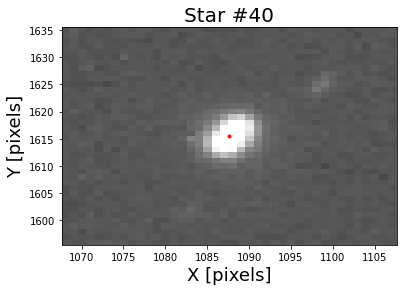

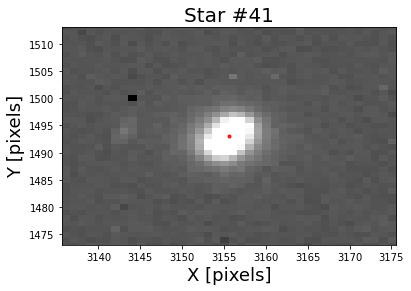

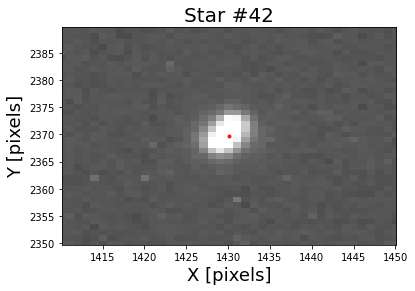

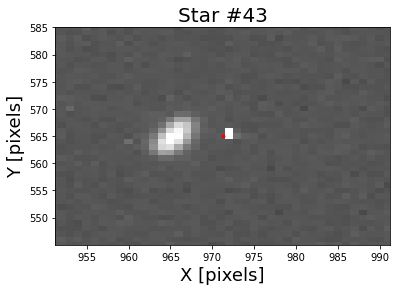

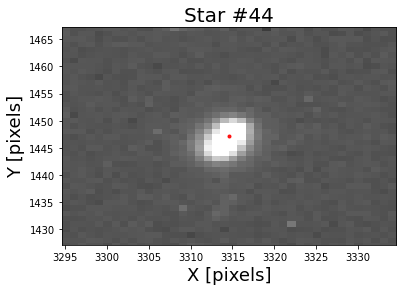

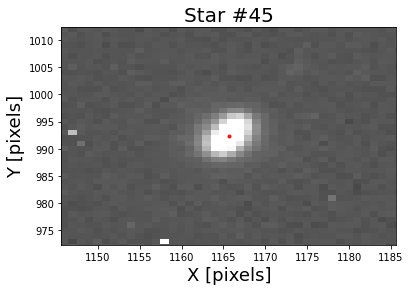

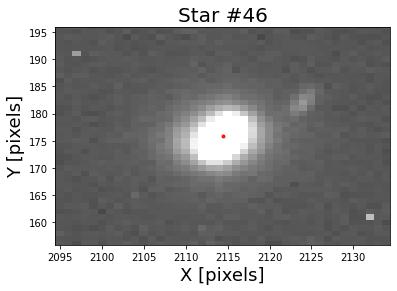

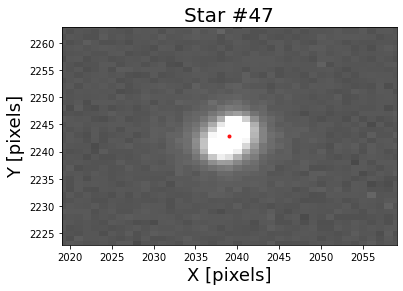

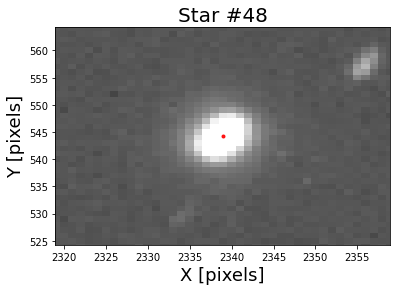

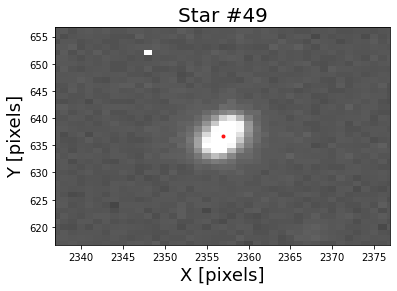

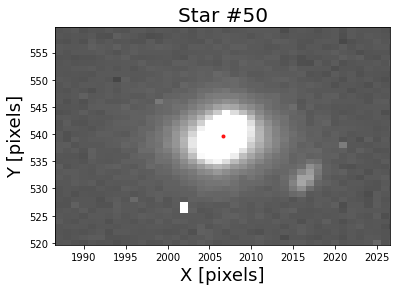

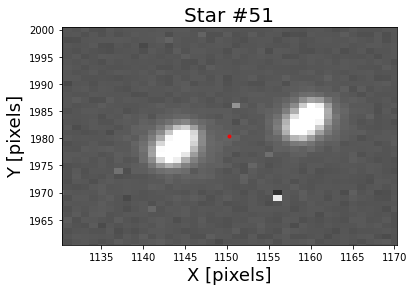

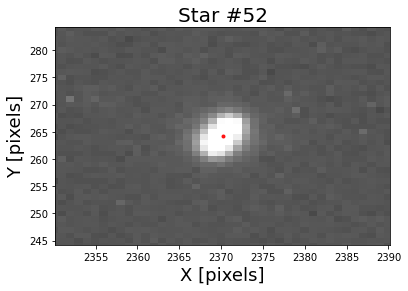

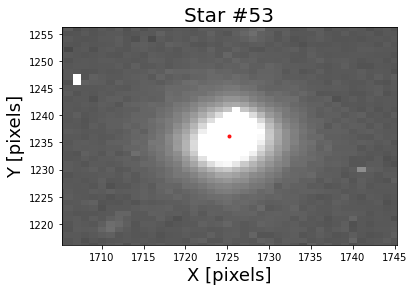

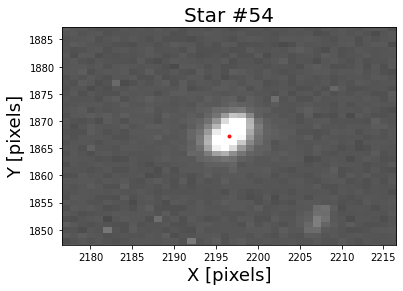

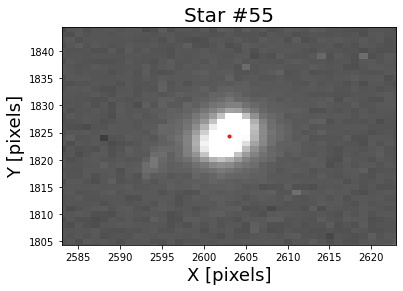

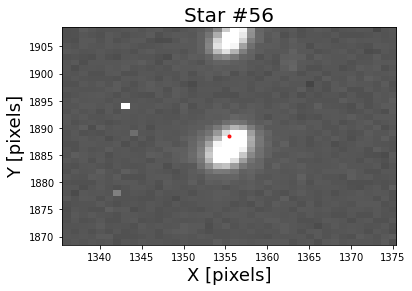

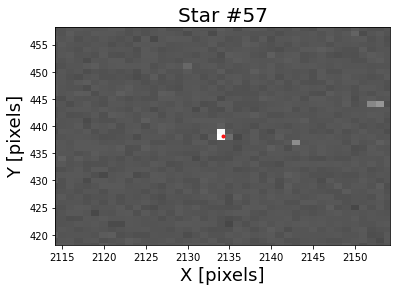

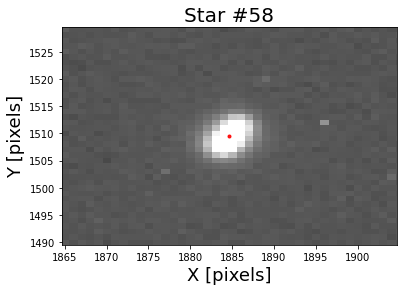

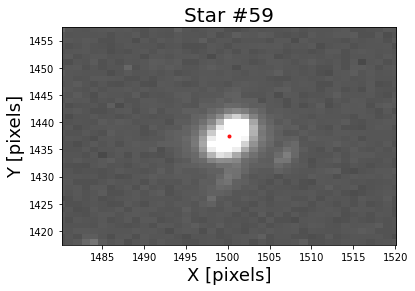

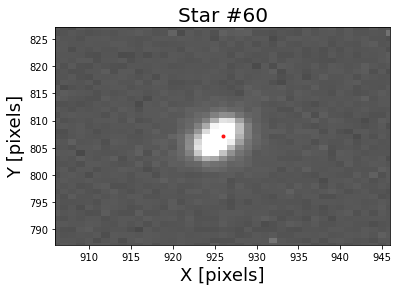

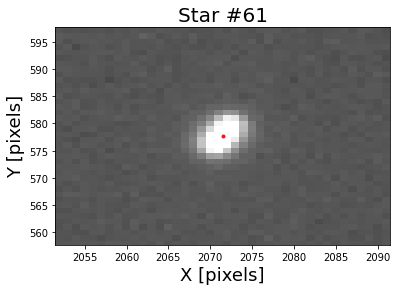

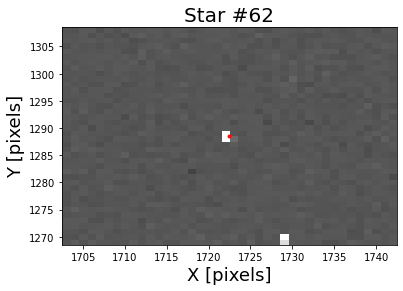

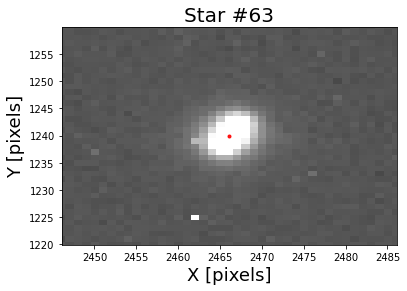

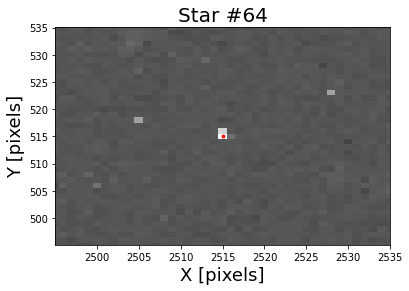

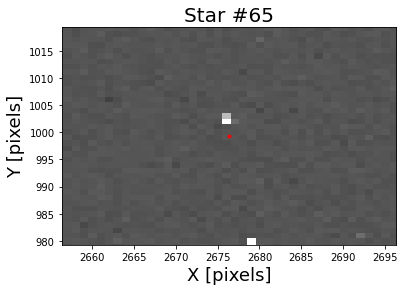

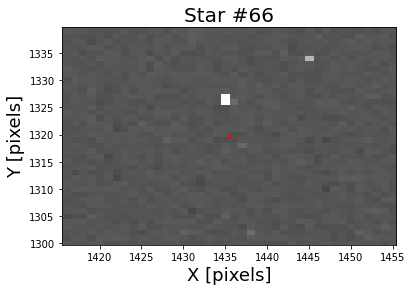

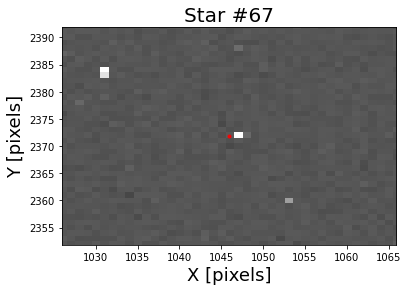

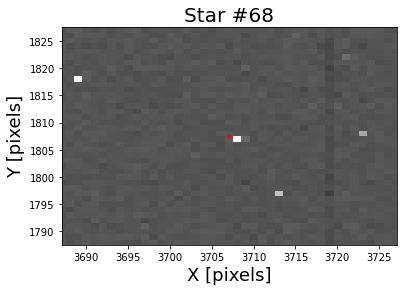

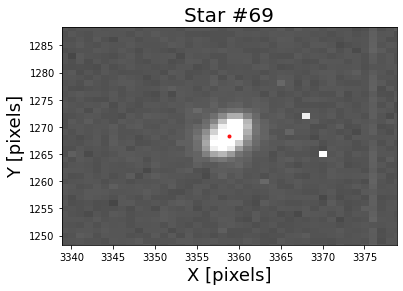

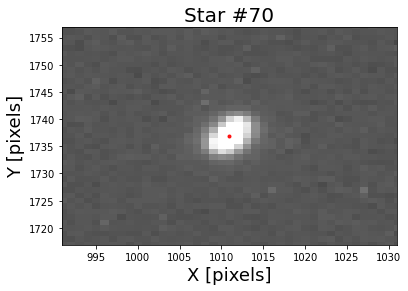

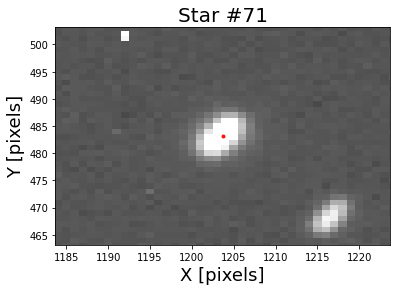

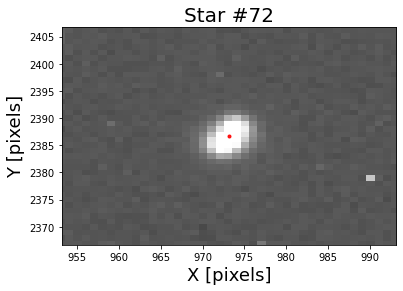

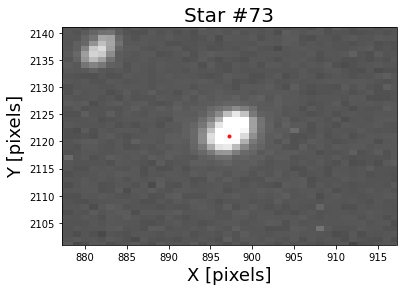

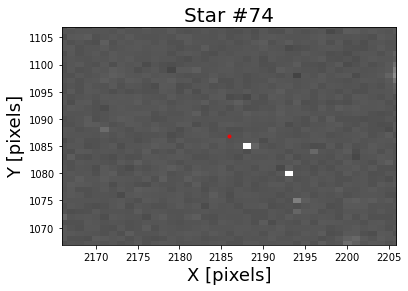

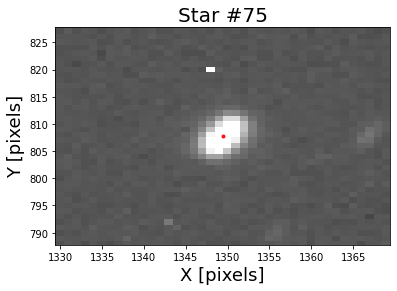

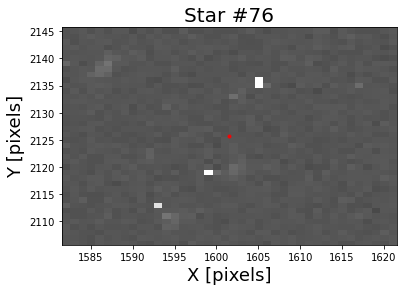

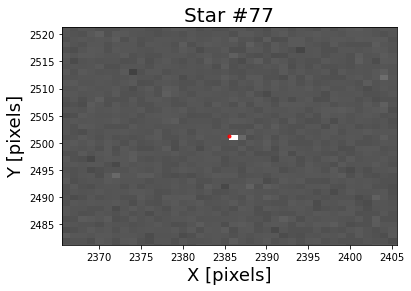

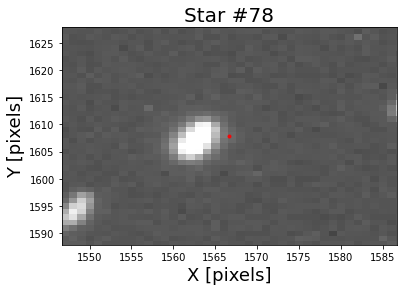

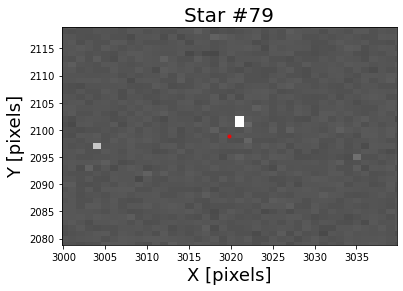

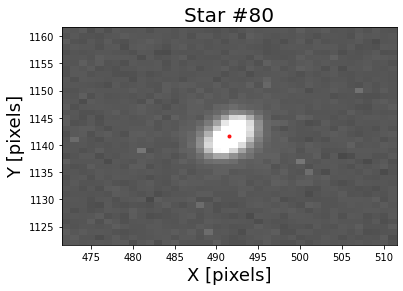

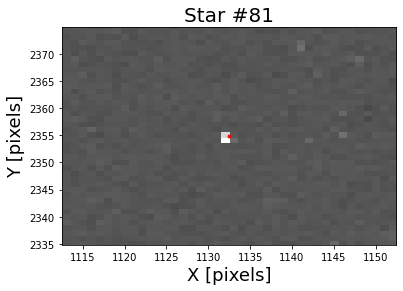

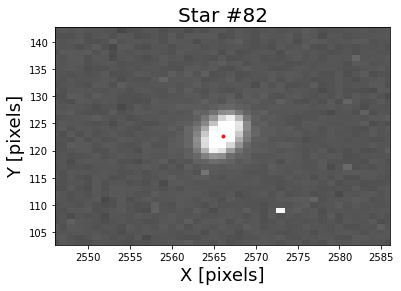

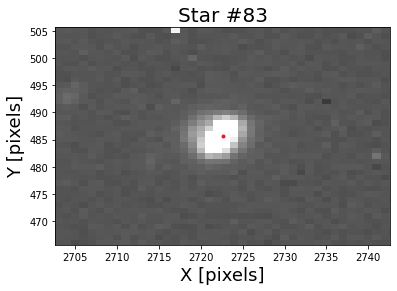

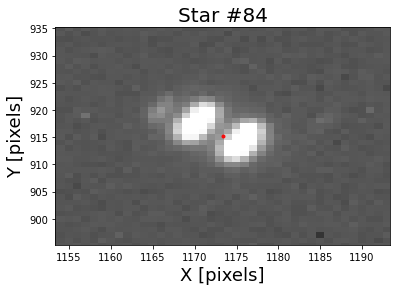

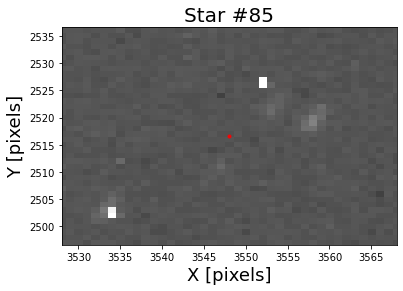

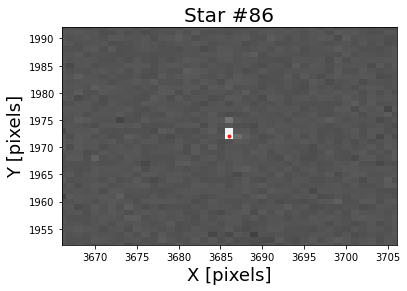

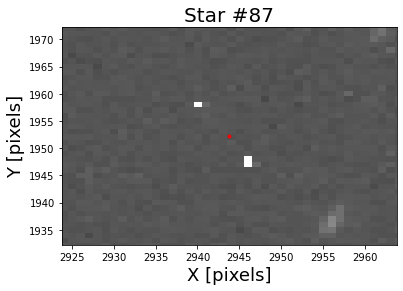

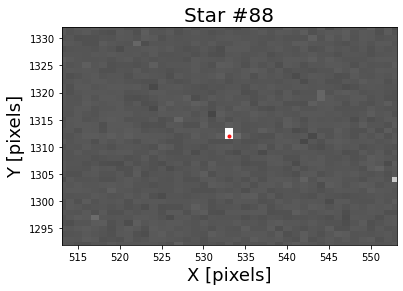

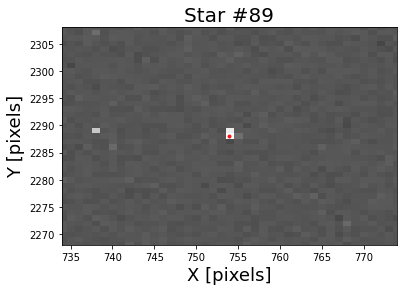

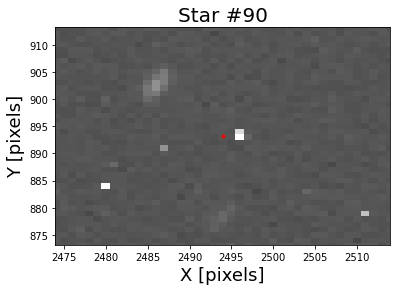

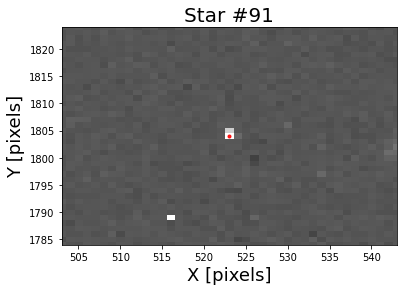

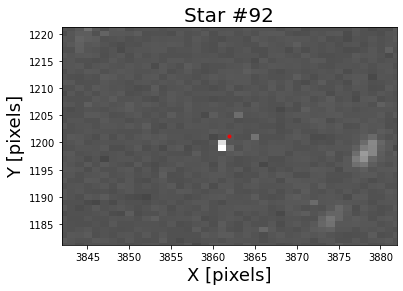

In [6]:
for i in range(star_locations.shape[0]):
    plt.imshow(data, aspect='auto', cmap = 'gray', 
           norm = LogNorm(vmax = 1e4, vmin = 1e2))
    plt.plot(star_locations[i,1], star_locations[i,0], '.', 
             color='r', alpha = 0.9)
    plt.xlim(star_locations[i,1]-20,star_locations[i,1]+20)
    plt.ylim(star_locations[i,0]-20,star_locations[i,0]+20)
    plt.xlabel("X [pixels]", size=18)
    plt.ylabel("Y [pixels]", size=18)
    plt.title("Star #{}".format(i+1), size = 20)
    plt.show()

# Okay, but how does it work?

Lets start with an image with a randomly placed star and build up from there. We can model our random star using a general code to plot a 2D Gaussian somewhere on the image.

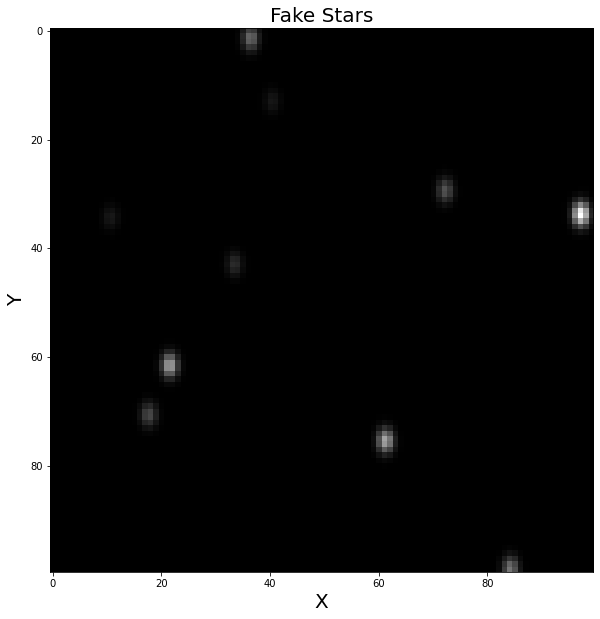

In [11]:
import random

def two_d_gaussian(x,y,ux,uy,sx,sy,A):
    return A*np.exp(-1*((x-ux)**2/(2*sx**2) + (y-uy)**2/(2*sy**2)))

def gen_fake_stars(NUM_FAKE_STARS, background = 0, WIDTHS = (2,3)):
    axis = np.linspace(-100,100,100)
    x,y = np.meshgrid(axis,axis)
    data = np.zeros_like(x) + background

    for i in range(NUM_FAKE_STARS):
        LOCATION = (random.uniform(-100,100), random.uniform(-100,100))
        AMPLITUDE = random.uniform(10,300)
        data += two_d_gaussian(x,y,LOCATION[0],LOCATION[1],WIDTHS[0],WIDTHS[1],AMPLITUDE)
        
    return data

NUM_FAKE_STARS = 10
data = gen_fake_stars(NUM_FAKE_STARS)


plt.figure(figsize=(10,10))
plt.imshow(data, cmap = 'gray')#, extent=[-100,100,-100,100])
plt.title("Fake Stars", size = 20)
plt.xlabel("X", size = 20)
plt.ylabel("Y", size = 20)
plt.show()

Question: What do we know about the stars? What differentiates them from the rest of the image?

Answer: Click to reveal. <!--The only thing we know is their approximate shape, and that they are brighter than the background. -->

# Centroiding

A centroid is the 'arithmetic mean' of a geometric shape. In this context, it is just a weigthed sum of the pixel values. The easiest way to conceptualize the centroid from a physicists perspective is to treat the pixel values as a mass distribution where the centroid is the center of mass.

The general formula for the centroid of a discrete distribution is:

$$
c_x = \frac{\sum{xw_i}}{\sum{w_i}}
$$

You can theoretically make the weights anything, however it is common to just the the pixel intensity.

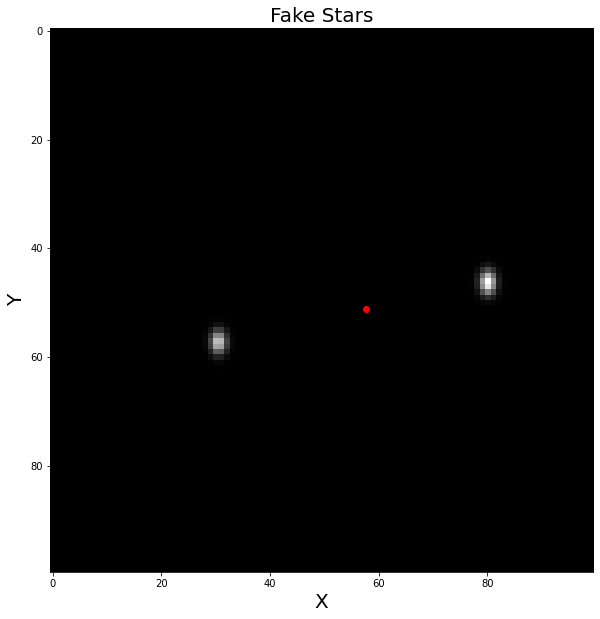

In [13]:
random.seed(60)

"""
A simple function for computing the centroid of a 2D image
"""
def centroid(image):
    
    xvals = np.arange(image.shape[1])
    yvals = np.arange(image.shape[0])
    centroid_x = np.sum(xvals*image)/np.sum(image)
    centroid_y = np.sum(yvals*image.T)/np.sum(image)
    
    return np.array([centroid_y, centroid_x])

data = gen_fake_stars(2, background = 0)

c = centroid(data)
plt.figure(figsize=(10,10))
plt.plot(c[1], c[0], 'o', color = 'r', alpha = 1)
plt.imshow(data, cmap = 'gray')
plt.title("Fake Stars", size = 20)
plt.xlabel("X", size = 20)
plt.ylabel("Y", size = 20)
plt.show()

What happens when there are two stars in the box? What happens when there is a non-zero background? These are important factors!

# Isolating Stars

There are generally two method that can be used to isolate stars. Look for things shaped like stars (this requires you to know what shape that is) or just look for bright things. The simpler method is to just look for bright things, and this is the example I will show you.

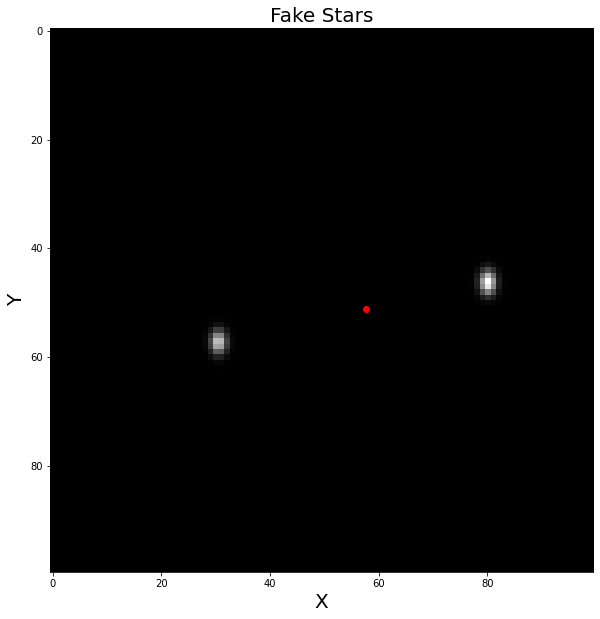

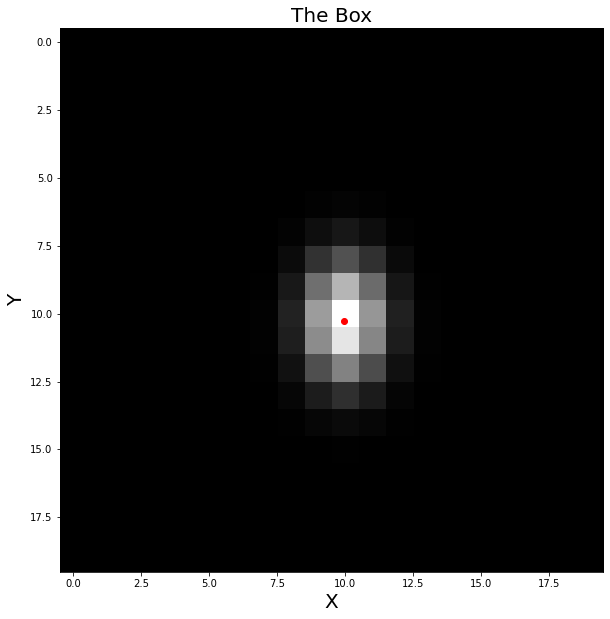

In [9]:
random.seed(60)

data = gen_fake_stars(2, background = 0)

c = centroid(data)

plt.figure(figsize=(10,10))
plt.plot(c[1], c[0], 'o', color = 'r', alpha = 1)
plt.imshow(data, cmap = 'gray')
plt.title("Fake Stars", size = 20)
plt.xlabel("X", size = 20)
plt.ylabel("Y", size = 20)
plt.show()

#find brightest pixel in the image
brightest_pixel = np.array([np.where(data == np.max(data))[0][0], np.where(data == np.max(data))[1][0]])

#create a "box" around that pixel
box = data[brightest_pixel[0]-10:brightest_pixel[0]+10,brightest_pixel[1]-10:brightest_pixel[1]+10]

#Get the centroid of that box
c = centroid(box)

plt.figure(figsize=(10,10))
plt.plot(c[1], c[0], 'o', color = 'r', alpha = 1)
plt.imshow(box, cmap = 'gray')
plt.title("The Box", size = 20)
plt.xlabel("X", size = 20)
plt.ylabel("Y", size = 20)
plt.show()

Question: What do we do now? How do we find the other star?

# Putting it all together

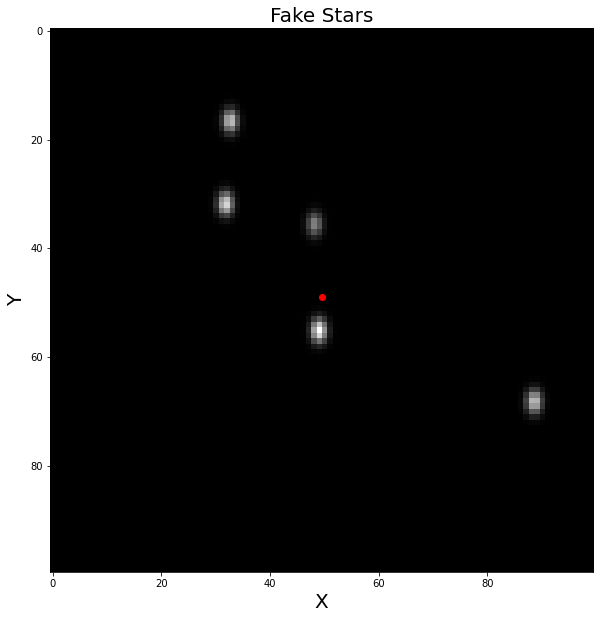

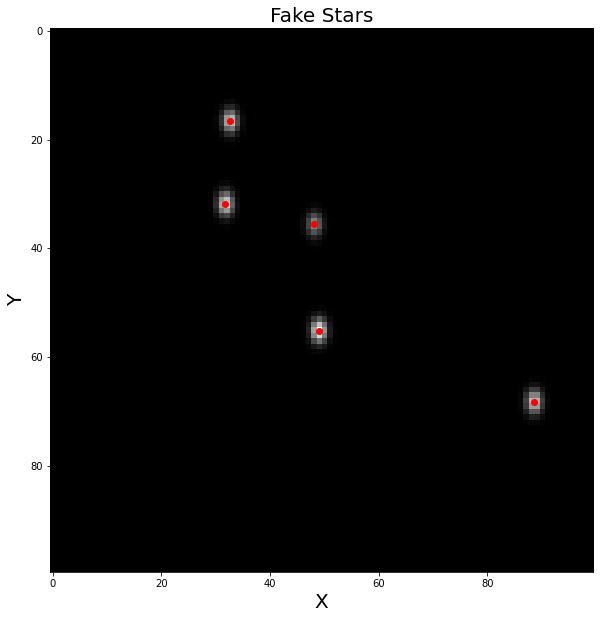

In [17]:
random.seed(61)

num_stars = 5
data = gen_fake_stars(num_stars, background = 10)

background = np.median(data)

c = centroid(data)

plt.figure(figsize=(10,10))
plt.plot(c[1], c[0], 'o', color = 'r', alpha = 1)
plt.imshow(data, cmap = 'gray')
plt.title("Fake Stars", size = 20)
plt.xlabel("X", size = 20)
plt.ylabel("Y", size = 20)
plt.show()

star_locations = []
BOX_SIZE = 10
im = data.copy()

for i in range(num_stars):
    
    #find brightest pixel in the image
    brightest_pixel = np.array([np.where(im == np.max(im))[0][0], np.where(im == np.max(im))[1][0]])

    #create a "box" around that pixel
    box = im[brightest_pixel[0]-BOX_SIZE:brightest_pixel[0]+BOX_SIZE+1,
             brightest_pixel[1]-BOX_SIZE:brightest_pixel[1]+BOX_SIZE+1]
    box -= background
    
    #Get the centroid of that box
    c = centroid(box)
    
    #Map the centroid of the box back onto the orginal image
    c -= np.array([box.shape[1]//2,box.shape[0]//2])
    c += brightest_pixel
    
    star_locations.append(c)
    
    #Remove that star from the image so it isn't the brightest pixel anymore
    box[:,:] = background
    
    
star_locations = np.array(star_locations)

plt.figure(figsize=(10,10))
plt.plot(star_locations[:,1], star_locations[:,0], 'o', color = 'r', alpha = 1)
plt.imshow(data, cmap = 'gray')
plt.title("Fake Stars", size = 20)
plt.xlabel("X", size = 20)
plt.ylabel("Y", size = 20)
plt.show()

Question: Why doesn't this code work in general? 